## GSEA results (figure 4b-d, extended data figure 10,11)

Here we import the GSEA results (enrichment analysis is done in R, see R subfolder of scripts folder). Here we load the results, visualize significance of a subset of gene sets for specific cell types and covariates discussed in the paper, and plot cell type proportions along the proximal to distal axis of the lung.

### Load modules, set paths, load files:

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from statsmodels.stats.multitest import multipletests

optional, for pretty code formatting:

In [2]:
%load_ext lab_black

set paths:

In [3]:
dir_GSEA_results = "../../results/covariate_modeling/GSEA/"
dir_figures = "../../results/figures/"
path_celltype_df = "../../supporting_files/celltype_structure_and_colors/manual_anns_grouped_order_and_colors.csv"
path_HLCA = "../../data/HLCA_core_h5ads/HLCA_v2.h5ad"
dir_ccf_modeling = "../../results/ccf_modeling/"

load files:

In [4]:
cts_ordered_df = pd.read_csv(path_celltype_df, index_col=0)
adata = sc.read_h5ad(path_HLCA)

get celltype names in bio order:

In [5]:
cts = cts_ordered_df.index.tolist()

create empty dictionary in which to store figures:

In [6]:
FIGURES = dict()

### Import GSEA results and generate related plots:

In [7]:
covariates = [
    "BMI",
    "age",
    "anatomical_region_ccf_score",
    "sexfemale",
    "smoking_status_num",
]
alpha = 0.05

In [8]:
gobp_results = dict()

Import results. For BMI, also store the number of sign. upregulated/downregulated sets.

In [9]:
gene_set_numbers_BMI = pd.DataFrame(
    index=cts,
    columns=["gobp_total", "gobp_n_up", "gobp_n_down", "gobp_perc_up"],
)

for ct in cts:
    ct_no_space = ct.replace(" ", "_")
    for cov in covariates:
        gobp_file_path = os.path.join(
            dir_GSEA_results, f"{ct_no_space}-{cov}-GO_BP-Total.tsv"
        )
        if os.path.exists(gobp_file_path):
            res = pd.read_csv(gobp_file_path, sep="\t", index_col=0)
            res = res.loc[res.FDR < alpha, :].copy()
            if cov == "BMI":
                n_genesets = res.shape[0]
                n_genesets_up = (res.Direction == "Up").sum()
                n_genesets_down = (res.Direction == "Down").sum()
                perc_genesets_up = round(n_genesets_up / n_genesets * 100, 0)
                #                 print(f"{ct} {cov} {n_genesets} ({perc_genesets_up}% up)")
                gene_set_numbers_BMI.loc[
                    ct, ["gobp_total", "gobp_n_up", "gobp_n_down", "gobp_perc_up"]
                ] = [
                    n_genesets,
                    n_genesets_up,
                    n_genesets_down,
                    perc_genesets_up,
                ]

            gobp_results[f"{ct}_{cov}"] = res

Sort number of cell types by total number of significant BMI-associated gene sets. The text in the paper, and the figures below will focus on these cell types for BMI:

In [10]:
gene_set_numbers_BMI.sort_values(by="gobp_total", inplace=True, ascending=False)

Show resulting table. You can see that certain top cell types have largely down-regulated gene sets:

In [11]:
gene_set_numbers_BMI

,gobp_total,gobp_n_up,gobp_n_down,gobp_perc_up
Alveolar macrophages,183,1,182,1.0
Secretory,178,16,162,9.0
Plasma cells,177,103,74,58.0
AT2,157,4,153,3.0
Plasmacytoid DCs,146,66,80,45.0
Basal,113,109,4,96.0
T cell lineage,66,37,29,56.0
Pericytes,61,36,25,59.0
Monocytes,31,27,4,87.0
Monocyte-derived Mph,25,4,21,16.0


We will show that balance of up-vs-downregulated gene sets in the following bar plot (extended data figure 8b). We only show the results for cell types that have at least 10 significantly BMI-associated gene sets.

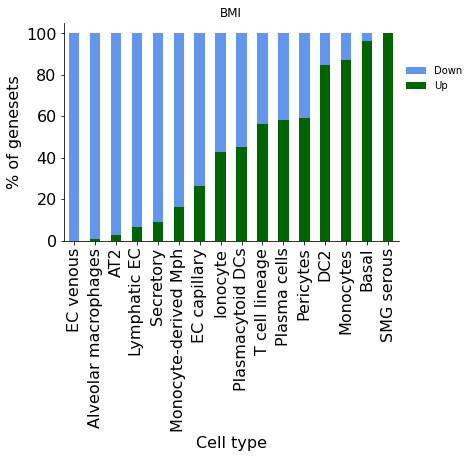

In [12]:
# normalize gene set proportions
gene_set_numbers_BMI_norm = (
    gene_set_numbers_BMI.loc[:, ["gobp_n_up", "gobp_n_down"]].divide(
        gene_set_numbers_BMI.gobp_total, axis=0
    )
    * 100
)
# keep only cell types with at least 10 gene sets
gene_set_numbers_BMI_norm = gene_set_numbers_BMI_norm.loc[
    gene_set_numbers_BMI.gobp_total >= 10, :
].copy()
# sort
gene_set_numbers_BMI_norm.sort_values(by="gobp_n_up", inplace=True)
# plot
fz = 16
with plt.rc_context(
    {
        "figure.figsize": (5, 3),
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots()

    gene_set_numbers_BMI_norm.loc[:, ["gobp_n_up", "gobp_n_down"]].plot(
        kind="bar",
        stacked=True,
        color=["darkgreen", "cornflowerblue"],
        ax=ax,  # custom_palette_1
    )
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], ["Down", "Up"], frameon=False, loc=(1.01, 0.67))
    plt.ylabel("% of genesets")
    plt.xlabel("Cell type")
    plt.title("BMI")
    plt.xticks(rotation=90)
    plt.show()
    FIGURES["ED11_BMI_genesets_up_down_per_ct"] = fig
    plt.close()

Now show a selection of significant gene sets for secretory cells, alveolar macrophages, plasma cells and AT2 cells (top 4 BMI cell types in terms of number of significantly associated gene sets):

Specify selected gene sets per cell type, for BMI:

In [13]:
selected_terms_BMI = dict()

In [14]:
selected_terms_BMI["Secretory"] = [
    "GO_LUNG_CELL_DIFFERENTIATION",  # differentiation
    "GO_CELLULAR_RESPONSE_TO_INSULIN_STIMULUS",  # insulin
    "GO_GLYCOPROTEIN_BIOSYNTHETIC_PROCESS",  # biosynthesis
]
selected_terms_BMI["AT2"] = [
    "GO_OXIDATIVE_PHOSPHORYLATION",  # respiration
    "GO_PEPTIDE_BIOSYNTHETIC_PROCESS",  # biosynthesis
    "GO_MITOTIC_DNA_REPLICATION",  # proliferation
    "GO_ATP_METABOLIC_PROCESS",  # metabolism
    "GO_GENERATION_OF_PRECURSOR_METABOLITES_AND_ENERGY",  # metabolism
]
selected_terms_BMI["Alveolar macrophages"] = [
    "GO_OXIDATIVE_PHOSPHORYLATION",
    "GO_PEPTIDE_BIOSYNTHETIC_PROCESS",
    "GO_RESPONSE_TO_TYPE_I_INTERFERON",
    "GO_CELLULAR_AMINO_ACID_METABOLIC_PROCESS",
]
selected_terms_BMI["Plasma cells"] = [
    "GO_CELL_CYCLE_DNA_REPLICATION",
    "GO_DNA_REPAIR",
    "GO_INFLAMMATORY_RESPONSE",
    "GO_OXIDATIVE_PHOSPHORYLATION",
]

reduced version, with selected gene sets:

In [15]:
def plot_GSEA_results(celltype_name, covariate_name, gobp_results, fz=15):
    """Function to plot barplot of GSEA results.
    Arguments:
    celltype_name
        str, name of cell type (for figure labels)
    covariate_name
        str, name of covariate (for figure labels)
    gobp_results
        pandas dataframe, containing the GSEA results for the cell type,
        including only the gene sets of interest
    Returns:
    matplotlib figure
    """
    with plt.rc_context(
        {
            "xtick.labelsize": fz,
            "ytick.labelsize": fz,
            "axes.spines.right": False,
            "axes.spines.top": False,
            "xtick.bottom": True,
            "ytick.left": True,
        }
    ):
        # direct significance depending on up or downregulation of gene set
        # or use only for coloring
        FDR_color = [
            np.log10(FDR) if direc == "Down" else -np.log10(FDR)
            for FDR, direc in zip(
                gobp_results.FDR,
                gobp_results.Direction,
            )
        ]
        # order: now independent of direction (can also make it dependent, using above code)
        FDR_order = -np.log10(gobp_results.FDR)
        FDR_values = -np.log10(gobp_results.FDR)
        # gene set names
        genesets = gobp_results.index
        # sort both based on x:
        genesets = [gs for _, gs in sorted(zip(FDR_order, genesets))]
        # clean up gene sets:
        genesets_clean = list()
        for gs in genesets:
            if (
                gs
                == "GO_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_PEPTIDE_ANTIGEN_VIA_MHC_CLASS_I"
            ):
                gs = "GO_MHC_I_ANTIGEN_PROCESSING_AND_PRESENTATION*"
            gs = gs[3:]  # remove "GO_"
            gs = gs.replace("_", " ")
            gs = gs.lower().capitalize()
            gs = (
                gs.replace("atp", "ATP")
                .replace("Atp", "ATP")
                .replace("dna", "DNA")
                .replace("Dna", "DNA")
                .replace("type i", "type I")
                .replace("Mhc i", "MHC-I")
                .replace("Interleukin 1 mediated", "IL-1-mediated")
                .replace("Tumor necrosis factor mediated", "TNF-mediated")
            )
            genesets_clean.append(gs)
        FDR_values = [FDR_v for _, FDR_v in sorted(zip(FDR_order, FDR_values))]
        FDR_color = [FDR_c for _, FDR_c in sorted(zip(FDR_order, FDR_color))]
        fig, ax = plt.subplots(figsize=(5, 0.3 * len(genesets)))
        ax.barh(
            y=genesets_clean,
            width=FDR_values,
            #         height=0.4,
            color=[
                "darkgreen" if direc > 0 else "cornflowerblue" for direc in FDR_color
            ],
        )
        plt.xlabel("-log10(p-value)", fontsize=fz)
        plt.ylabel("GO:BP term", fontsize=fz)
        covariate_name_for_title = covariate_name.replace("_", " ")
        plt.title(
            f"{celltype_name}, {covariate_name_for_title}",
            fontsize=fz,
        )
        tick_interval = 1
        if max(FDR_values) > 5:
            tick_interval = 2
        plt.xticks(np.arange(0, max(FDR_values), tick_interval))

        # plt.xlim((0, 9))
        plt.grid(False)
        plt.show()
        return fig

In [16]:
cov = "BMI"

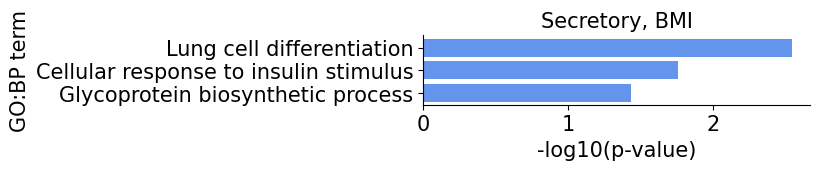

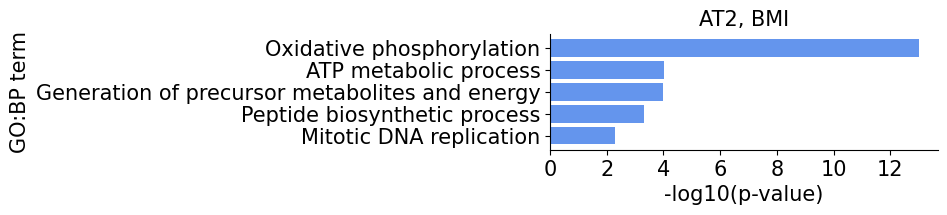

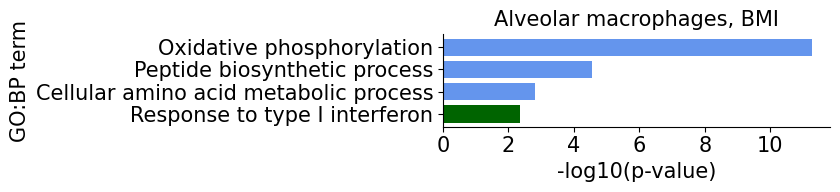

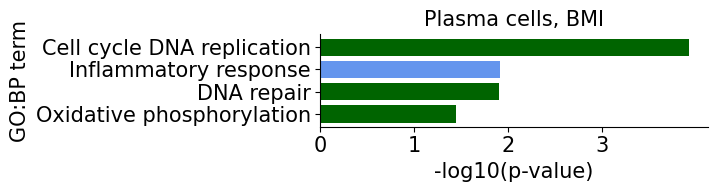

In [17]:
for ct, ct_terms in selected_terms_BMI.items():
    res = gobp_results[f"{ct}_{cov}"].loc[ct_terms, :]
    FIGURES[f"4d_{cov}_{ct}_genesets"] = plot_GSEA_results(ct, cov, res)

Show the same type of figures for anatomical region ccf score, for the 3 major airway epithelial cell types (Secretory, multiciliated, and basal cells) (figure 4b):

To show:  
- MHC-I presentation; 
- oxidative phosphorylation;
- planar cell polarity;
- IL-1 and TNFA down in all three airway epithelial types.
- keratinization and cornification down in multiciliated
- redox down in secretory and basal
- development up in multiciliated

towards distal

In [18]:
selected_terms_ccf = dict()
selected_terms_ccf["Secretory"] = [
    "GO_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_PEPTIDE_ANTIGEN_VIA_MHC_CLASS_I",
    "GO_OXIDATIVE_PHOSPHORYLATION",
    "GO_REGULATION_OF_ESTABLISHMENT_OF_PLANAR_POLARITY",
    "GO_INTERLEUKIN_1_MEDIATED_SIGNALING_PATHWAY",
    "GO_TUMOR_NECROSIS_FACTOR_MEDIATED_SIGNALING_PATHWAY",
    "GO_CELL_REDOX_HOMEOSTASIS",
    "GO_CORNIFICATION",
]
selected_terms_ccf["Multiciliated"] = [
    "GO_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_PEPTIDE_ANTIGEN_VIA_MHC_CLASS_I",
    "GO_OXIDATIVE_PHOSPHORYLATION",
    "GO_REGULATION_OF_ESTABLISHMENT_OF_PLANAR_POLARITY",
    "GO_INTERLEUKIN_1_MEDIATED_SIGNALING_PATHWAY",
    "GO_TUMOR_NECROSIS_FACTOR_MEDIATED_SIGNALING_PATHWAY",
    "GO_KERATINIZATION",
    "GO_LUNG_EPITHELIUM_DEVELOPMENT",
]
selected_terms_ccf["Basal"] = [
    "GO_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_PEPTIDE_ANTIGEN_VIA_MHC_CLASS_I",
    "GO_OXIDATIVE_PHOSPHORYLATION",
    "GO_REGULATION_OF_ESTABLISHMENT_OF_PLANAR_POLARITY",
    "GO_INTERLEUKIN_1_MEDIATED_SIGNALING_PATHWAY",
    "GO_TUMOR_NECROSIS_FACTOR_MEDIATED_SIGNALING_PATHWAY",
    "GO_CELL_REDOX_HOMEOSTASIS",
]

Secretory


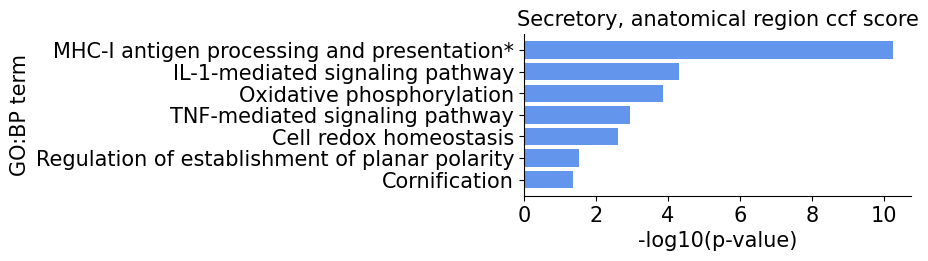

Multiciliated


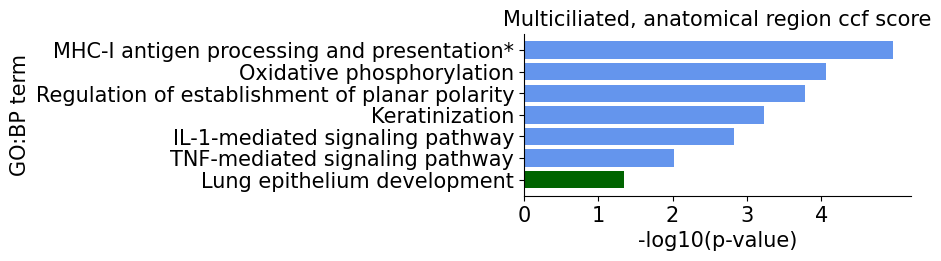

Basal


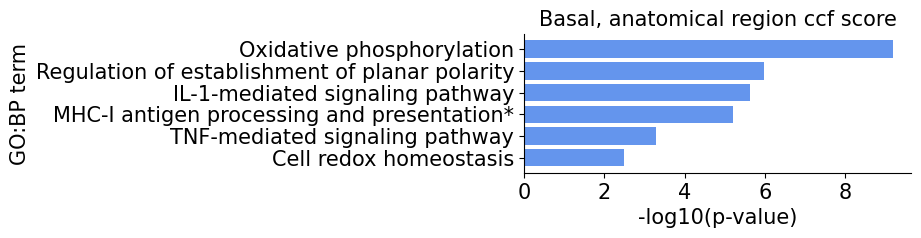

In [19]:
cov = "anatomical_region_ccf_score"
for ct, ct_terms in selected_terms_ccf.items():
    print(ct)
    res = gobp_results[f"{ct}_{cov}"].loc[ct_terms, :]
    FIGURES[f"4c_{cov}_{ct}_genesets"] = plot_GSEA_results(ct, cov, res)

## Plot cell type proportions along anatomical region ccf score axis (proximal to distal):

Generate a column that combines tissue digestion protocol and tissue sampling method: these can both affect the cell type composition of a sample, and are sometimes confounded, hence will be modeled together:

In [20]:
adata.obs["digestion_sample_type"] = [
    f"{dig} ({st})"
    for dig, st in zip(adata.obs.tissue_dissociation_protocol, adata.obs.sample_type)
]

In [21]:
len(adata.obs.digestion_sample_type.unique())

10

In [22]:
dig_st_cats = sorted(adata.obs.digestion_sample_type.unique())

Add color mapping:

In [23]:
dig_to_col_colblind = {
    "Cold protease 1h (biopsy)": "#501BD8",
    "Cold protease 1h (brush)": "#1E88E5",
    "Cold protease 1h (scraping)": "#07DAFF",
    "Cold protease overnight (donor_lung)": "#A3D8EF",
    "Collagenase + Elastase + DNAse (surgical_resection)": "#FE97F6",
    "Collagenase A + DNAse (donor_lung)": "#188F31",
    "Collagenase D + DNAse (biopsy)": "#C3BE47",
    "Collagenase D + DNAse (brush)": "#70B490",
    "Collagenase D + DNAse (donor_lung)": "#DAF40F",
    "Dispase + collagenase (donor_lung)": "#B866DB",
}

In [24]:
tab10_colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

In [25]:
dig_to_col = {cat: col for cat, col in zip(dig_st_cats, tab10_colors)}

For each cell type, plot cell type fractions with anatomical location ccf score. Color by tissue digestion protocol + tissue sampling type:

plot subselection of cell types for main figure:

In [26]:
cts_for_main = ["Basal", "Multiciliated", "Secretory", "Ionocyte", "Neuroendocrine"]

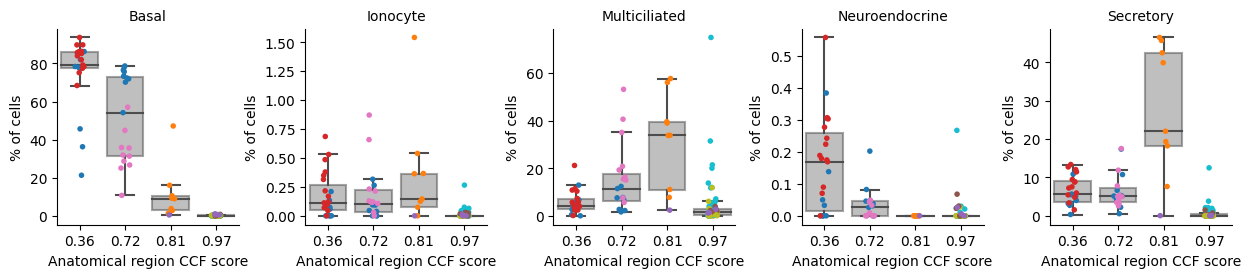

In [27]:
fz = 10
with plt.rc_context(
    {
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fignumber = 0
    cts = cts_for_main
    n_figures = len(cts)
    n_cols = 6
    n_rows = int(np.ceil(n_figures / 3))
    fig = plt.figure(figsize=(2.5 * n_cols, 2.5 * n_rows))
    fig_count = 1
    for ct in sorted(cts):
        ax = fig.add_subplot(n_rows, n_cols, fig_count)
        # get basal cell count per sample
        ct_counts_per_sample = (
            adata.obs.groupby(["manual_ann_grouped", "sample"])
            .agg({"manual_ann_grouped": "count"})
            .loc[ct, :]
        ).rename(columns={"manual_ann_grouped": "ct_count"})
        # get sample-level info (not ct specific)
        sample_info = (
            adata.obs.groupby(["sample"])
            .agg(
                {
                    "manual_ann_grouped": "count",
                    "digestion_sample_type": "first",
                    "anatomical_region_ccf_score": "first",
                    "sample_type": "first",
                }
            )
            .rename(columns={"manual_ann_grouped": "n_cells_total"})
        )
        sample_info["ct_count"] = ct_counts_per_sample.loc[
            sample_info.index, "ct_count"
        ]
        sample_info["perc_ct"] = sample_info.ct_count / sample_info.n_cells_total * 100
        # filter out noses (since modeled separately), i.e. ccf == 0
        sample_info = sample_info.loc[
            ~(sample_info.anatomical_region_ccf_score == 0), :
        ].copy()
        # now plot:
        x = sample_info.anatomical_region_ccf_score
        y = sample_info.perc_ct
        cols = sample_info.digestion_sample_type
        # exclude categories with fewer than min_n_samples samples:
        min_n_samples = 4  # 5
        cat_counts = x.value_counts()
        cats_to_drop = cat_counts.index[cat_counts < min_n_samples]
        xy_filter = ~x.isin(cats_to_drop)
        x_filtered = x[xy_filter]
        y_filtered = y[xy_filter]
        # cols_filtered = [col for col, filt in zip(cols, xy_filter) if filt]
        cols_filtered = cols[xy_filter]
        sns.stripplot(
            x=x_filtered,
            y=y_filtered,
            ax=ax,
            hue=cols_filtered,
            size=4,
            palette=dig_to_col,
        )
        sns.boxplot(
            x=x_filtered,
            y=y_filtered,
            saturation=0.5,
            fliersize=0,
            ax=ax,
            color="grey",
            boxprops=dict(alpha=0.5),
        )
        ax.set_title(ct, fontsize=fz)
        ax.set_ylabel(f"% of cells")
        ax.set_xlabel("Anatomical region CCF score")
        ax.get_legend().remove()
        fig_count += 1
    plt.tight_layout()
    plt.show()
    plt.close()
    FIGURES["4b_ct_prop_with_ccf_colored_by_digsampletype"] = fig

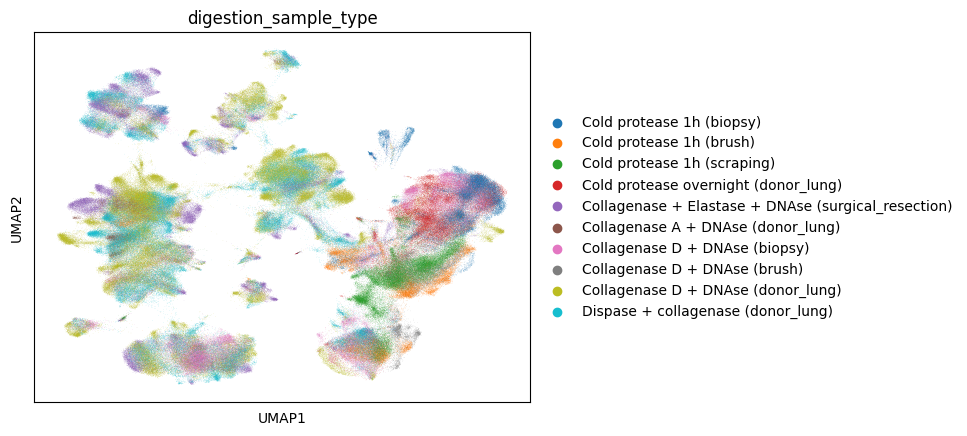

In [28]:
FIGURES["4d_ct_prop_with_ccf_colord_by_digsampletype_legend"] = sc.pl.umap(
    adata, color="digestion_sample_type", palette=dig_to_col, return_fig=True
)

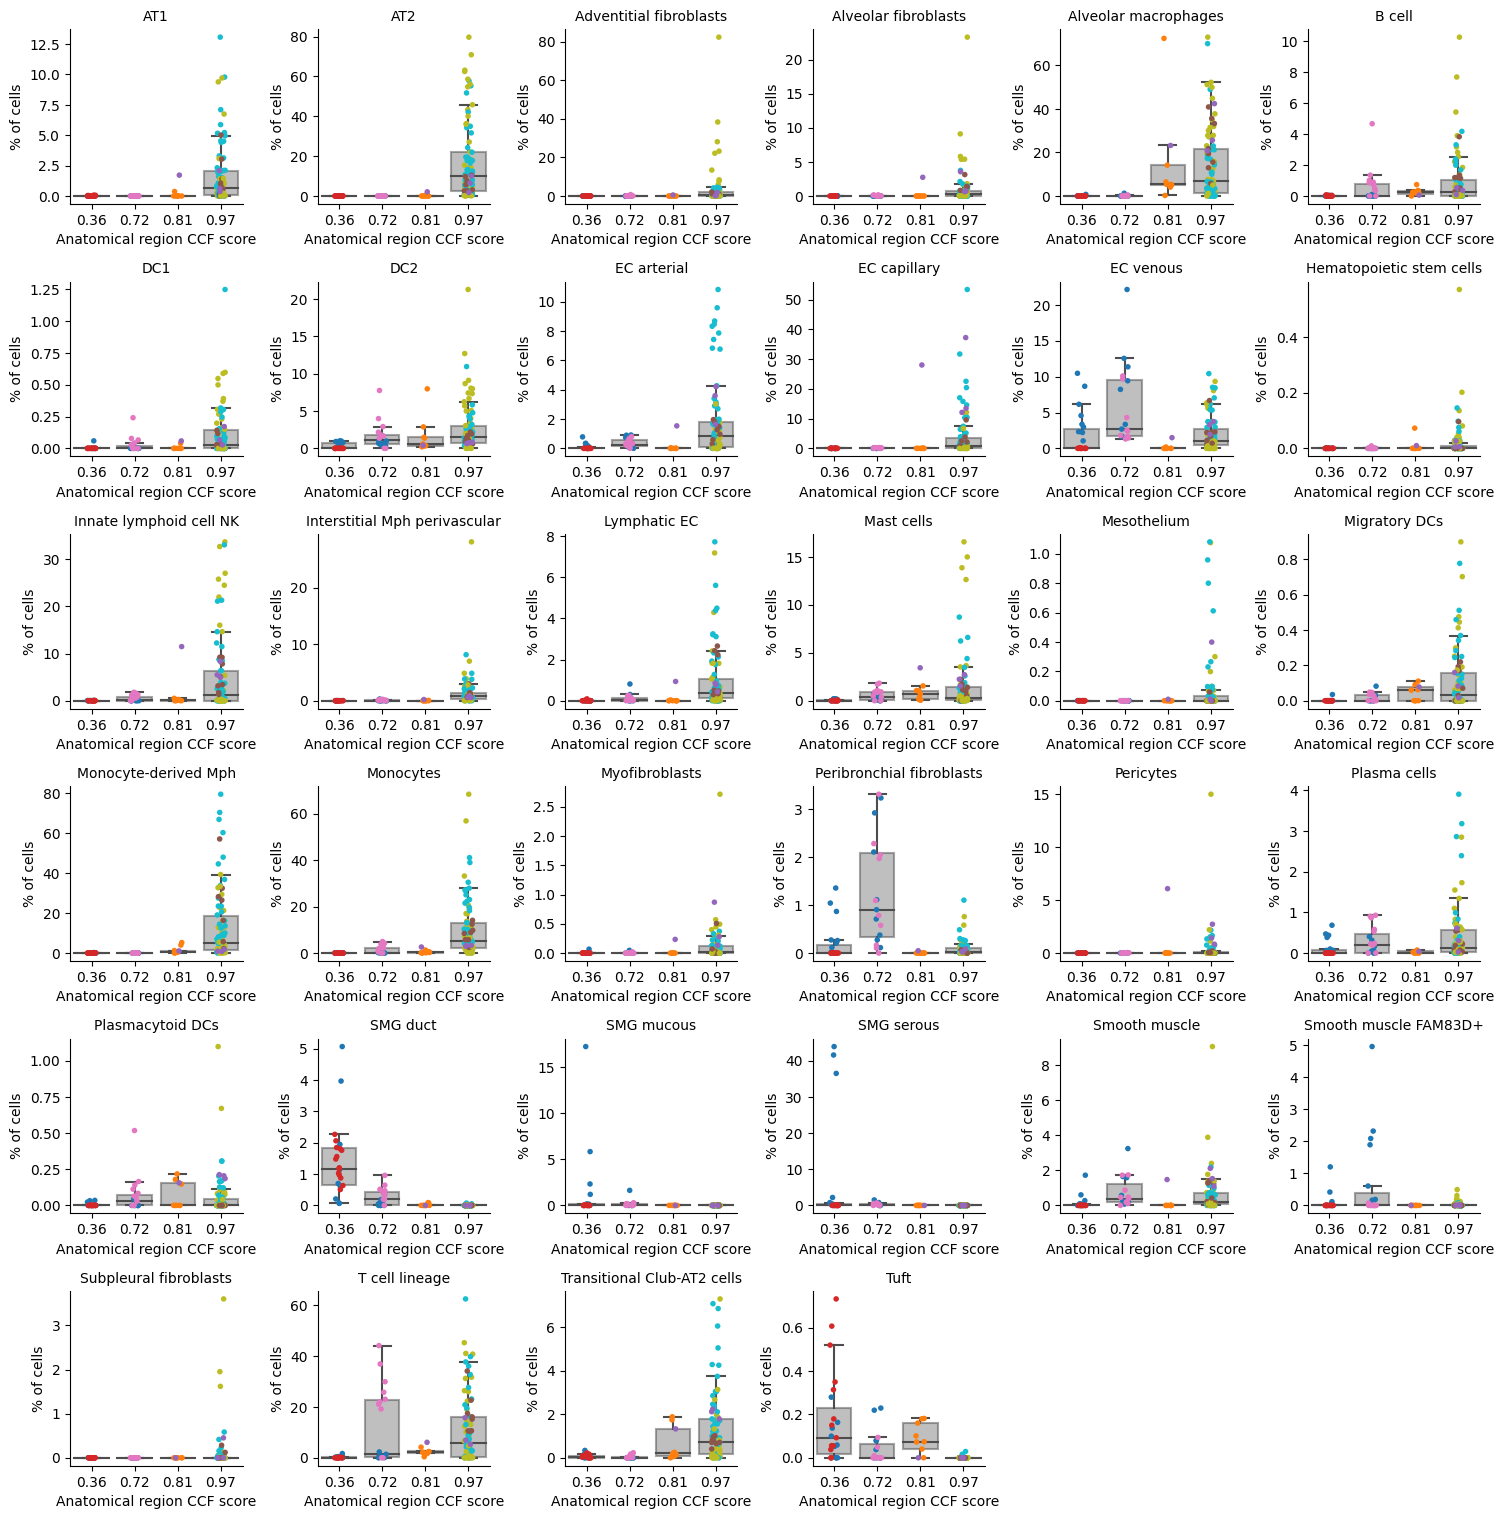

In [30]:
fz = 10
with plt.rc_context(
    {
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fignumber = 0
    cts = [ct for ct in cts_ordered_df.index if ct not in cts_for_main]
    n_figures = len(cts)
    n_cols = 6
    n_rows = int(np.ceil(n_figures / 3))
    fig = plt.figure(figsize=(2.5 * n_cols, 2.5 * n_rows))
    fig_count = 1
    for ct in sorted(cts):
        ax = fig.add_subplot(n_rows, n_cols, fig_count)
        # get basal cell count per sample
        ct_counts_per_sample = (
            adata.obs.groupby(["manual_ann_grouped", "sample"])
            .agg({"manual_ann_grouped": "count"})
            .loc[ct, :]
        ).rename(columns={"manual_ann_grouped": "ct_count"})
        # get sample-level info (not ct specific)
        sample_info = (
            adata.obs.groupby(["sample"])
            .agg(
                {
                    "manual_ann_grouped": "count",
                    "digestion_sample_type": "first",
                    "anatomical_region_ccf_score": "first",
                    "sample_type": "first",
                }
            )
            .rename(columns={"manual_ann_grouped": "n_cells_total"})
        )
        sample_info["ct_count"] = ct_counts_per_sample.loc[
            sample_info.index, "ct_count"
        ]
        sample_info["perc_ct"] = sample_info.ct_count / sample_info.n_cells_total * 100
        # filter out noses (since modeled separately), i.e. ccf == 0
        sample_info = sample_info.loc[
            ~(sample_info.anatomical_region_ccf_score == 0), :
        ].copy()
        # now plot:
        x = sample_info.anatomical_region_ccf_score
        y = sample_info.perc_ct
        cols = sample_info.digestion_sample_type
        # exclude categories with fewer than min_n_samples samples:
        min_n_samples = 4  # 5
        cat_counts = x.value_counts()
        cats_to_drop = cat_counts.index[cat_counts < min_n_samples]
        xy_filter = ~x.isin(cats_to_drop)
        x_filtered = x[xy_filter]
        y_filtered = y[xy_filter]
        # cols_filtered = [col for col, filt in zip(cols, xy_filter) if filt]
        cols_filtered = cols[xy_filter]
        sns.stripplot(
            x=x_filtered,
            y=y_filtered,
            ax=ax,
            hue=cols_filtered,
            size=4,
            palette=dig_to_col,
        )
        sns.boxplot(
            x=x_filtered,
            y=y_filtered,
            saturation=0.5,
            fliersize=0,
            ax=ax,
            color="grey",
            boxprops=dict(alpha=0.5),
        )
        ax.set_title(ct, fontsize=fz)
        ax.set_ylabel(f"% of cells")
        ax.set_xlabel("Anatomical region CCF score")
        ax.get_legend().remove()
        fig_count += 1
    plt.tight_layout()
    plt.show()
    plt.close()
    FIGURES["ED_10_ct_prop_with_ccf_colored_by_digsampletype_excl_modeling"] = fig

Check number of samples per ccf score (same across all cell types):

In [31]:
x_filtered.value_counts()

0.97    90
0.36    23
0.72    19
0.81     9
Name: anatomical_region_ccf_score, dtype: int64

### Store figures:

In [32]:
FIGURES

{'ED11_BMI_genesets_up_down_per_ct': <Figure size 432x288 with 1 Axes>,
 '4d_BMI_Secretory_genesets': <Figure size 500x90 with 1 Axes>,
 '4d_BMI_AT2_genesets': <Figure size 500x150 with 1 Axes>,
 '4d_BMI_Alveolar macrophages_genesets': <Figure size 500x120 with 1 Axes>,
 '4d_BMI_Plasma cells_genesets': <Figure size 500x120 with 1 Axes>,
 '4c_anatomical_region_ccf_score_Secretory_genesets': <Figure size 500x210 with 1 Axes>,
 '4c_anatomical_region_ccf_score_Multiciliated_genesets': <Figure size 500x210 with 1 Axes>,
 '4c_anatomical_region_ccf_score_Basal_genesets': <Figure size 500x180 with 1 Axes>,
 '4b_ct_prop_with_ccf_colored_by_digsampletype': <Figure size 1500x500 with 5 Axes>,
 '4d_ct_prop_with_ccf_colord_by_digsampletype_legend': <Figure size 640x480 with 1 Axes>,
 'ED_10_ct_prop_with_ccf_colored_by_digsampletype_excl_modeling': <Figure size 1500x3000 with 34 Axes>}

In [ ]:
for figname, fig in FIGURES.items():
    print("Storing", figname)
    fig.savefig(
        os.path.join(dir_figures, f"{figname}.png"),
        bbox_inches="tight",
        dpi=140,
        transparent=True,
    )
    plt.close()